In [1]:
import requests
from tqdm import tqdm
from os.path import join as oj
import tables, numpy
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi
from skimage import data
import pickle as pkl
from skimage.util import img_as_float
from sklearn import metrics
import h5py
from copy import deepcopy
from skimage.filters import gabor_kernel
import gabor_feats
from sklearn.linear_model import RidgeCV
import seaborn as sns
from scipy.io import loadmat
import numpy.linalg as npl
out_dir = '/scratch/users/vision/data/gallant/vim_2_crcns'
from run import *

In [2]:
(U, alphas, _) = pkl.load(open(oj(out_dir, f'decomp_mot_energy.pkl'), 'rb'))

In [3]:
alphas.shape

(6555,)

In [3]:
U.shape

(7200, 7200)

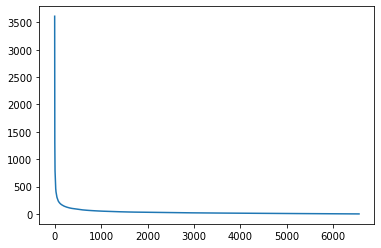

In [4]:
plt.plot(alphas)

# download data

In [2]:
def download(datafile, username, password, out_dir):
    '''
    Params
    ------
    datafile
    '''
    
    URL = 'https://portal.nersc.gov/project/crcns/download/index.php'
    login_data = dict(
        username=username,
        password=password,
        fn=datafile,
        submit='Login' 
    )

    with requests.Session() as s:
        local_filename = oj(out_dir, login_data['fn'].split('/')[-1])
        print(local_filename)
        r = s.post(URL, data=login_data, stream=True)
        with open(local_filename, 'wb') as f:
            for chunk in tqdm(r.iter_content(chunk_size=1024)):
                if chunk:
                    f.write(chunk)
                    
uname = 'csinva'
pwd = 'password'
dset = 'vim-2'
fnames = ['Stimuli.tar.gz', 'VoxelResponses_subject1.tar.gz', 'anatomy.zip', 'checksums.md5', 'filelist.txt', 'docs']
for fname in fnames:
    fname = oj(dset, fname)
#     download(fname, uname, pwd, out_dir)

In [49]:
ls /scratch/users/vision/data/gallant/vim_2_crcns

anatomy.zip    docs          Stimuli.mat     VoxelResponses_subject1.mat
checksums.md5  filelist.txt  Stimuli.tar.gz  VoxelResponses_subject1.tar.gz


In [23]:
!du -sh /scratch/users/vision/data/gallant/vim_2_crcns
# next extract the tars
# next unzip the zips

6.9G	/scratch/users/vision/data/gallant/vim_2_crcns


In [27]:
!ls /scratch/users/vision/data/gallant/vim_2_crcns/*.gz |xargs -n1 tar -xzf # extract the tar files

# responses

In [3]:
f = tables.open_file(oj(out_dir, 'VoxelResponses_subject1.mat'))
# f.listNodes # Show all variables available
data = f.get_node('/rt')[:] # training responses: 7200 (timepoints) x 73728
# plt.imshow(np.isnan(data))
roi = f.get_node('/roi/v1lh')[:].flatten() # structure containing volume matrices (64x64x18) with indices corresponding to each roi in each hemisphere
v1lh_idx = numpy.nonzero(roi==1)[0]
v1lh_resp = data[v1lh_idx]

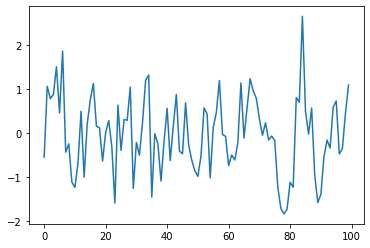

In [12]:
plt.plot(v1lh_resp[100, :100])

In [ ]:
plt.figure(dpi=300)
plt.imshow(v1lh_resp[:200, :200])
plt.axis('off')

In [ ]:
f2 = tables.open_file(oj(out_dir, 'Stimuli.mat'))
im = f2.get_node('/st')[100].transpose()
plt.imshow(im)

In [134]:
str(xs[0]).split(' ')[0]

['/roi/FFAlh', '(EArray(18,', '64,', '64),', 'zlib(3))', "''"]

In [168]:
f = tables.open_file(oj(out_dir, 'VoxelResponses_subject1.mat'))
xs = []
nums = []
for x in f.get_node('/roi'):
    xs.append(x)
    nums.append(np.array(f.get_node(x)).nonzero()[0].sum())
# sns.barplot(x=x, y=nums)
print([str(x) for x in xs])

["/roi/FFAlh (EArray(18, 64, 64), zlib(3)) ''", "/roi/FFArh (EArray(18, 64, 64), zlib(3)) ''", "/roi/IPlh (EArray(18, 64, 64), zlib(3)) ''", "/roi/IPrh (EArray(18, 64, 64), zlib(3)) ''", "/roi/MTlh (EArray(18, 64, 64), zlib(3)) ''", "/roi/MTplh (EArray(18, 64, 64), zlib(3)) ''", "/roi/MTprh (EArray(18, 64, 64), zlib(3)) ''", "/roi/MTrh (EArray(18, 64, 64), zlib(3)) ''", "/roi/OBJlh (EArray(18, 64, 64), zlib(3)) ''", "/roi/OBJrh (EArray(18, 64, 64), zlib(3)) ''", "/roi/PPAlh (EArray(18, 64, 64), zlib(3)) ''", "/roi/PPArh (EArray(18, 64, 64), zlib(3)) ''", "/roi/RSCrh (EArray(18, 64, 64), zlib(3)) ''", "/roi/STSrh (EArray(18, 64, 64), zlib(3)) ''", "/roi/VOlh (EArray(18, 64, 64), zlib(3)) ''", "/roi/VOrh (EArray(18, 64, 64), zlib(3)) ''", "/roi/latocclh (EArray(18, 64, 64), zlib(3)) ''", "/roi/latoccrh (EArray(18, 64, 64), zlib(3)) ''", "/roi/v1lh (EArray(18, 64, 64), zlib(3)) ''", "/roi/v1rh (EArray(18, 64, 64), zlib(3)) ''", "/roi/v2lh (EArray(18, 64, 64), zlib(3)) ''", "/roi/v2rh (EAr

In [15]:
# calculate standard deviations
f = tables.open_file(oj(out_dir, 'VoxelResponses_subject1.mat'))
rva = np.array(f.get_node('/rva')[:]) # 73728 (voxels) x 10 (trials) x 540 (timepoints)
sigmas = np.nanmean(np.nanstd(rva, axis=1), axis=-1)
out_name = oj(out_dir, f'out_rva_sigmas.h5')
save_h5(sigmas, out_name)

/accounts/projects/vision/.local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/accounts/projects/vision/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


In [ ]:
# normalize resps
resps_name = oj(out_dir, 'VoxelResponses_subject1.mat')
for dset in ['rt', 'rv']:
    Y = np.array(tables.open_file(resps_name).get_node(f'/{dset}')[:]) # training responses: 73728 (voxels) x 7200 (timepoints)
    Y -= np.nanmean(Y, axis=1).reshape(-1, 1)
    Y /= (np.nanstd(Y, axis=1).reshape(-1, 1) + 1e-8)
    save_h5(Y, oj(out_dir, f'{dset}_norm.h5'))

In [44]:
Y = load_h5(oj(out_dir, 'rt_norm.h5') )
Y_test = load_h5(oj(out_dir, 'rv_norm.h5') )
Y_test_init = np.array(tables.open_file(resps_name).get_node(f'/rv')[:]) # training responses: 73728 (voxels) x 7200 (timepoints)

In [ ]:
plt.plot(Y_test[150])
plt.plot(Y_test_init[150] * 10)
plt.show()

In [ ]:
plt.figure(dpi=300)
plt.imshow(Y_test_init[:300])
plt.ylabel('neurons')
plt.xlabel('timepoints')
plt.tight_layout()
plt.show()

# stimuli

In [45]:
SAMPLING_FREQ = 15
DOWNSAMPLE = 2
N_TRAIN = 7200
N_TEST = 540
OFFSET = SAMPLING_FREQ // 2
NUM_FEATS = 1280

In [46]:
f2 = tables.open_file(oj(out_dir, 'Stimuli.mat'))
f2.get_node(f'/sv').shape

(8100, 3, 128, 128)

In [ ]:
# find the relevant stimuli
for dset, N in zip(['sv'], [N_TEST]): # 'st', 'sv'
    f2 = tables.open_file(oj(out_dir, 'Stimuli.mat'))
    ims = np.zeros((N, 128 // DOWNSAMPLE, 128 // DOWNSAMPLE)).astype(np.int)
    for i in tqdm(range(N)):
        ims[i] = deepcopy(f2.get_node(f'/{dset}')[OFFSET + i * SAMPLING_FREQ].transpose())[::DOWNSAMPLE, ::DOWNSAMPLE].mean(axis=-1)

    out_name = oj(out_dir, f'out_{dset}.h5')
    save_h5(ims, out_name)

In [ ]:
# convert stimuli to feature vectors
for dset, N in zip(['sv'], [N_TEST]): # 'st', 'sv'
    f = h5py.File(oj(out_dir, f'out_{dset}.h5'), 'r')
    feats = np.zeros((N, NUM_FEATS))
    for i in tqdm(range(N)):
        feats[i] = gabor_feats.all_feats(deepcopy(f['data'][i]))

    out_name = oj(out_dir, f'out_{dset}_feats.h5')
    save_h5(feats, out_name)

In [37]:
# normalize things
for dset, N in zip(['st', 'sv'], [N_TRAIN, N_TEST]): # 'st', 'sv'
    for suffix in ['', '_feats']:
        feats_name = oj(out_dir, f'out_{dset}{suffix}.h5')
        data = load_h5(feats_name)
        data = data.reshape(data.shape[0], -1).astype(np.float32)
        data -= data.mean(axis=1).reshape(-1, 1)
        data /= (data.std(axis=1).reshape(-1, 1) + 1e-8)
        out_name = oj(out_dir, f'out_{dset}{suffix}_norm.h5')
        save_h5(data, out_name)

In [62]:
# decompose the training data
'''
suffix = '' # _feats
X = np.array(h5py.File(oj(out_dir, f'out_st{suffix}.h5'), 'r')['data'])
X = X.reshape(X.shape[0], -1)
U, s, Vh = npl.svd(X)
save_pkl((U, s, Vh), oj(out_dir, f'decomp{suffix}.pkl'))
'''

# matlab feats
suffix = '' # _feats
X = np.array(loadmat(oj(out_dir, 'mot_energy_feats_st.mat'))['S_fin'])
U, s, Vh = npl.svd(X)
save_pkl((U, s, Vh), oj(out_dir, f'decomp_mot_energy.pkl'))

(7200, 6555)


# features

In [50]:
X = np.array(loadmat(oj(out_dir, 'mot_energy_feats_st.mat'))['S_fin'])
X_test = np.array(loadmat(oj(out_dir, 'mot_energy_feats_sv.mat'))['S_fin'])

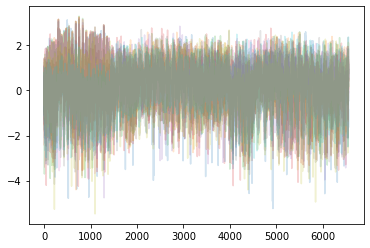

In [61]:
plt.plot(X_test[0:10].T, alpha=0.2)
plt.show()

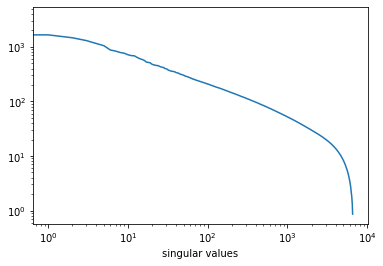

In [69]:
(U, s, Vh) = pkl.load(open(oj(out_dir, f'decomp_mot_energy.pkl'), 'rb'))
plt.loglog(sorted(s)[::-1])
plt.xlabel('singular values')
plt.show()